In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00


In [2]:
# ============================================================
# 1. Setup & Imports
# ============================================================
import os
import gc
import yaml
import shutil
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Device configuration

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# পাথ সেটআপ
BASE_DIR = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK_DIR = Path("/kaggle/working/traffic_simclr_project")
SPLIT_DIR = WORK_DIR / "dataset_split"
SSL_WEIGHTS = WORK_DIR / "simclr_backbone.pth"
DATA_YAML = WORK_DIR / "data.yaml"

# Create folder
WORK_DIR.mkdir(parents=True, exist_ok=True)
if SPLIT_DIR.exists(): shutil.rmtree(SPLIT_DIR)

# ============================================================
# 2. Data Preparation (VOC -> YOLO)
# ============================================================
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes: continue
            cls_id = classes.index(cls)
            
            bnd = obj.find("bndbox")
            xmin, ymin = float(bnd.find("xmin").text), float(bnd.find("ymin").text)
            xmax, ymax = float(bnd.find("xmax").text), float(bnd.find("ymax").text)
            
            # YOLO xywh normalize
            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def prepare_data(base_path, split_path, ratios=(0.7, 0.2, 0.1)):
    all_pairs = []
    for ext in ["*.jpg", "*.png", "*.jpeg"]:
        for img in Path(base_path).rglob(ext):
            xml = img.with_suffix(".xml")
            if xml.exists(): all_pairs.append((img, xml))
            
    print(f"Total Images Found: {len(all_pairs)}")
    random.shuffle(all_pairs)
    
    n = len(all_pairs)
    train = all_pairs[:int(n*ratios[0])]
    val = all_pairs[int(n*ratios[0]):int(n*(ratios[0]+ratios[1]))]
    test = all_pairs[int(n*(ratios[0]+ratios[1])):]
    
    splits = {"train": train, "val": val, "test": test}
    
    for name, files in splits.items():
        (split_path/name/"images").mkdir(parents=True, exist_ok=True)
        (split_path/name/"labels").mkdir(parents=True, exist_ok=True)
        for img, xml in files:
            shutil.copy(img, split_path/name/"images"/img.name)
            voc2yolo(xml, CLASSES, split_path/name/"labels"/f"{img.stem}.txt")
            
    # Creating YAML file
    yaml_data = {
        "path": str(split_path),
        "train": "train/images",
        "val": "val/images",
        "test": "test/images",
        "nc": len(CLASSES),
        "names": CLASSES
    }
    with open(DATA_YAML, "w") as f:
        yaml.dump(yaml_data, f)
        
    print("✓ Dataset Preparation Complete")

prepare_data(BASE_DIR, SPLIT_DIR)


Using device: cuda
Total Images Found: 23678
✓ Dataset Preparation Complete


In [4]:
# ============================================================
# 3. SimCLR Implementation
# ============================================================
# 3.1 Two-View Dataset (SimCLR requires 2 augmented views of the same image)
class TwoViewDataset(Dataset):
    def __init__(self, root_dirs, transform):
        self.files = []
        for r in root_dirs:
            self.files.extend(list(Path(r).glob("*.jpg")) + list(Path(r).glob("*.png")))
        self.transform = transform
        
    def __len__(self): return len(self.files)
    
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.transform(img), self.transform(img)

# 3.2 Augmentations
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
])

# 3.3 NT-Xent Loss Function
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.size(0)
    
    out = torch.cat([z1, z2], dim=0)
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=out.device)).bool()
    
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)
    pos_sim = torch.exp(torch.sum(z1 * z2, dim=-1) / temperature)
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    
    loss = -torch.log(pos_sim / sim_matrix.sum(dim=-1))
    return loss.mean()


➤ Starting SimCLR Pre-training...
   Using Device: cuda | Total GPUs: 2
   ✅ Wrapping model with DataParallel for 2 GPUs


Epoch 1/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 1 Avg Loss: 4.7071


Epoch 2/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 2 Avg Loss: 4.6782


Epoch 3/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 3 Avg Loss: 4.6689


Epoch 4/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive(): 
      ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 4 Avg Loss: 4.6690


Epoch 5/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():        if w

Epoch 5 Avg Loss: 4.6646


Epoch 6/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 6 Avg Loss: 4.6572


Epoch 7/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 7 Avg Loss: 4.6584


Epoch 8/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 8 Avg Loss: 4.6533


Epoch 9/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 9 Avg Loss: 4.6515


Epoch 10/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 10 Avg Loss: 4.6553


Epoch 11/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 11 Avg Loss: 4.6494


Epoch 12/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 12 Avg Loss: 4.6476


Epoch 13/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 13 Avg Loss: 4.6458


Epoch 14/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 14 Avg Loss: 4.6456


Epoch 15/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 15 Avg Loss: 4.6457


Epoch 16/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 16 Avg Loss: 4.6449


Epoch 17/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 17 Avg Loss: 4.6416


Epoch 18/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 18 Avg Loss: 4.6427


Epoch 19/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 19 Avg Loss: 4.6418


Epoch 20/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()Exception ignored in:     
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>if w.is_alive():
    
  if w.is_alive(): Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 166

Epoch 20 Avg Loss: 4.6401


Epoch 21/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 21 Avg Loss: 4.6369


Epoch 22/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 22 Avg Loss: 4.6343


Epoch 23/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 23 Avg Loss: 4.6331


Epoch 24/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 24 Avg Loss: 4.6240


Epoch 25/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 25 Avg Loss: 4.6216


Epoch 26/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 26 Avg Loss: 4.6171


Epoch 27/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 27 Avg Loss: 4.6131


Epoch 28/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():    self._shutdown_workers()
 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
         ^ ^ ^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 28 Avg Loss: 4.6079


Epoch 29/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 29 Avg Loss: 4.6049


Epoch 30/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 30 Avg Loss: 4.6051


Epoch 31/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 31 Avg Loss: 4.6014


Epoch 32/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 32 Avg Loss: 4.6055


Epoch 33/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 33 Avg Loss: 4.6007


Epoch 34/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 34 Avg Loss: 4.5932


Epoch 35/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 35 Avg Loss: 4.5985


Epoch 36/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 36 Avg Loss: 4.5927


Epoch 37/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 37 Avg Loss: 4.5936


Epoch 38/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 38 Avg Loss: 4.5979


Epoch 39/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 39 Avg Loss: 4.5975


Epoch 40/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 40 Avg Loss: 4.5948


Epoch 41/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 41 Avg Loss: 4.5963


Epoch 42/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 42 Avg Loss: 4.5932


Epoch 43/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 43 Avg Loss: 4.5959


Epoch 44/50:   0%|          | 0/332 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():
self._shutdown_workers()Exception ignored in:  
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff5db59e8e0>   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  
    if w.is_alive(): Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 44 Avg Loss: 4.5934


Epoch 45/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 45 Avg Loss: 4.5955


Epoch 46/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 46 Avg Loss: 4.5912


Epoch 47/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 47 Avg Loss: 4.5945


Epoch 48/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 48 Avg Loss: 4.5907


Epoch 49/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 49 Avg Loss: 4.5933


Epoch 50/50:   0%|          | 0/332 [00:00<?, ?it/s]

Epoch 50 Avg Loss: 4.5925
✓ SimCLR Backbone saved at: /kaggle/working/traffic_simclr_project/simclr_backbone.pth


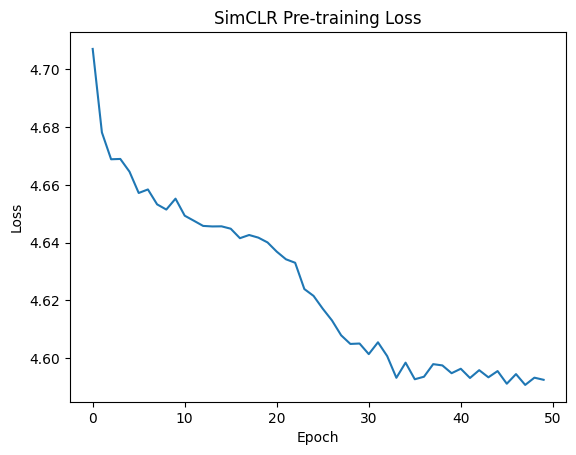

In [5]:
import torch.nn as nn

# ============================================================
# 4. SimCLR Pre-training Loop (Multi-GPU Fixed)
# ============================================================
def train_simclr(epochs=50, batch_size=64):
    print("\n➤ Starting SimCLR Pre-training...")

# 1. Device Detection
# We will select 'cuda' directly, DataParallel will handle the rest
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gpu_count = torch.cuda.device_count()
    print(f"   Using Device: {device} | Total GPUs: {gpu_count}")
    
    # 2. Model Load
    temp_model = YOLO("yolo12s.pt")
    
    # 3. Extract Backbone
    backbone = temp_model.model.model[0]

    # ➤➤ FIX 1: Gradients Enable
    for param in backbone.parameters():
        param.requires_grad = True

    # ➤➤ FIX 2: Move to CUDA first, then wrap with DataParallel
    backbone = backbone.to(device)
    
    if gpu_count > 1:
        print(f"   ✅ Wrapping model with DataParallel for {gpu_count} GPUs")
        backbone = nn.DataParallel(backbone)
        
    backbone.train()
    
    # 4. Data Loader
    train_dirs = [SPLIT_DIR/"train/images", SPLIT_DIR/"val/images"]
    dataset = TwoViewDataset(train_dirs, simclr_transform)
    
    # Setting num_workers = 4 or 8 in multi-GPU increases speed
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    
    # 5. Optimizer
    optimizer = torch.optim.Adam(backbone.parameters(), lr=1e-3)
    
    losses = []
    
    # 6. Training Loop
    for epoch in range(epochs):
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for v1, v2 in pbar:
            # ➤➤ FIX 3: Send data only to 'device' (cuda), not to '0,1'
            v1, v2 = v1.to(device), v2.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            # DataParallel Automatically splits input and sends it to 2 GPUs
            f1 = backbone(v1).flatten(1)
            f2 = backbone(v2).flatten(1)
            
            # Loss Calculation
            loss = nt_xent_loss(f1, f2)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            
        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")
        
    # Save Weights
    # Using DataParallel requires .module to access the original model
    if gpu_count > 1:
        state_dict = backbone.module.state_dict()
    else:
        state_dict = backbone.state_dict()
        
    torch.save(state_dict, SSL_WEIGHTS)
    print(f"✓ SimCLR Backbone saved at: {SSL_WEIGHTS}")
    
    # Plot
    plt.plot(losses)
    plt.title("SimCLR Pre-training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# Run (give batch size 64, since there are 2 GPUs)
train_simclr(epochs=50, batch_size=64)

In [6]:
# ============================================================
# 5. Fine-tuning YOLOv12 with Pre-trained Weights
# ============================================================
print("\n➤ Starting Fine-tuning Task...")

# 1. Loading a fresh model
model = YOLO("yolo12s.pt")

# 2. Loading pre-trained SimCLR weights (in Backbone)
print(f"Loading SimCLR weights from {SSL_WEIGHTS}...")
try:
    ssl_state_dict = torch.load(SSL_WEIGHTS)
   # Injecting weight into the first layer of YOLO
    model.model.model[0].load_state_dict(ssl_state_dict, strict=False)
    print("✓ Weights transferred successfully!")
except Exception as e:
    print(f"⚠ Error loading weights: {e}")

# 3. Normal Detection Training
model.train(
    data=str(DATA_YAML),
    epochs=50,
    imgsz=640,
    batch=64,
    device='0,1',
    project=str(WORK_DIR / "outputs"),
    name="yolo12_simclr_finetuned",
    exist_ok=True
)



➤ Starting Fine-tuning Task...
Loading SimCLR weights from /kaggle/working/traffic_simclr_project/simclr_backbone.pth...
✓ Weights transferred successfully!
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_simclr_project/data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01,


➤ Evaluating Final Model...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1885.9±575.6 MB/s, size: 74.9 KB)
val: Scanning /kaggle/working/traffic_simclr_project/dataset_split/val/labels.cache... 4736 images, 13 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4736/4736 7.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 296/296 4.5it/s 1:05
                   all       4736      46205      0.679      0.709      0.743       0.51
              Rickshaw       3874      12065       0.78      0.853        0.9      0.625
                   Bus       3926      10308      0.784      0.847      0.889       0.65
                 Truck        248        274      0.473      0.474      0.474      0.369
                  Bike       2117       3174      0.749      0.78

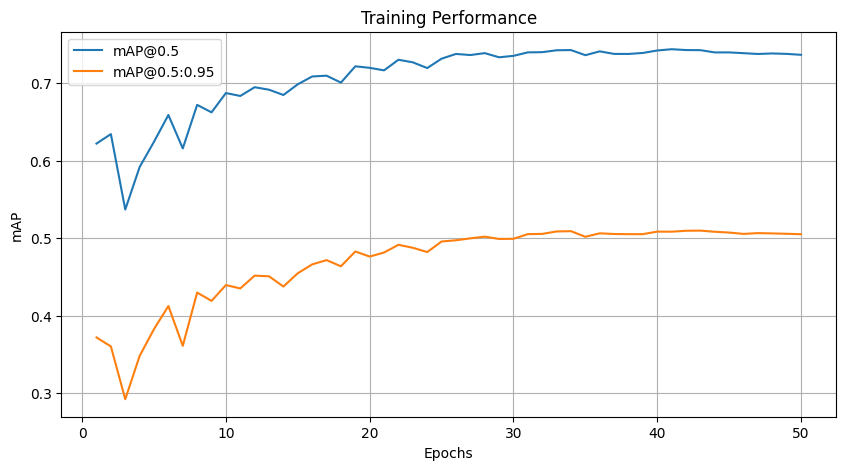

In [7]:

# ============================================================
# 6. Evaluation & Results
# ============================================================
print("\n➤ Evaluating Final Model...")
metrics = model.val()

print(f"mAP@0.5: {metrics.box.map50}")
print(f"mAP@0.5:0.95: {metrics.box.map}")

# Show result graph
results_csv = Path(model.trainer.save_dir) / "results.csv"
if results_csv.exists():
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    
    plt.figure(figsize=(10, 5))
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    plt.title('Training Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

➤ Generating Confusion Matrix on Test Set...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1395.6±553.9 MB/s, size: 65.6 KB)
val: Scanning /kaggle/working/traffic_simclr_project/dataset_split/test/labels... 2368 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2368/2368 1.5Kit/s 1.6s
val: New cache created: /kaggle/working/traffic_simclr_project/dataset_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 148/148 4.4it/s 33.3s
                   all       2368      23574      0.703      0.662       0.72      0.491
              Rickshaw       1969       6246      0.819      0.827      0.904      0.629
                   Bus       1950       5245      0.814      0.832      0.898       0.66
                 Truck        115        126    

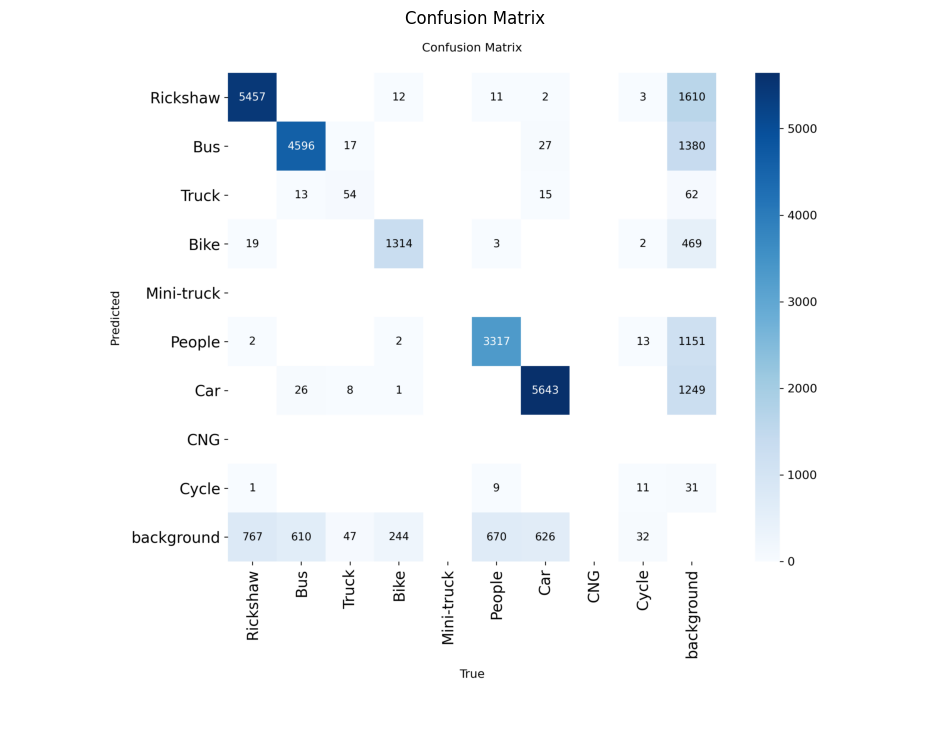

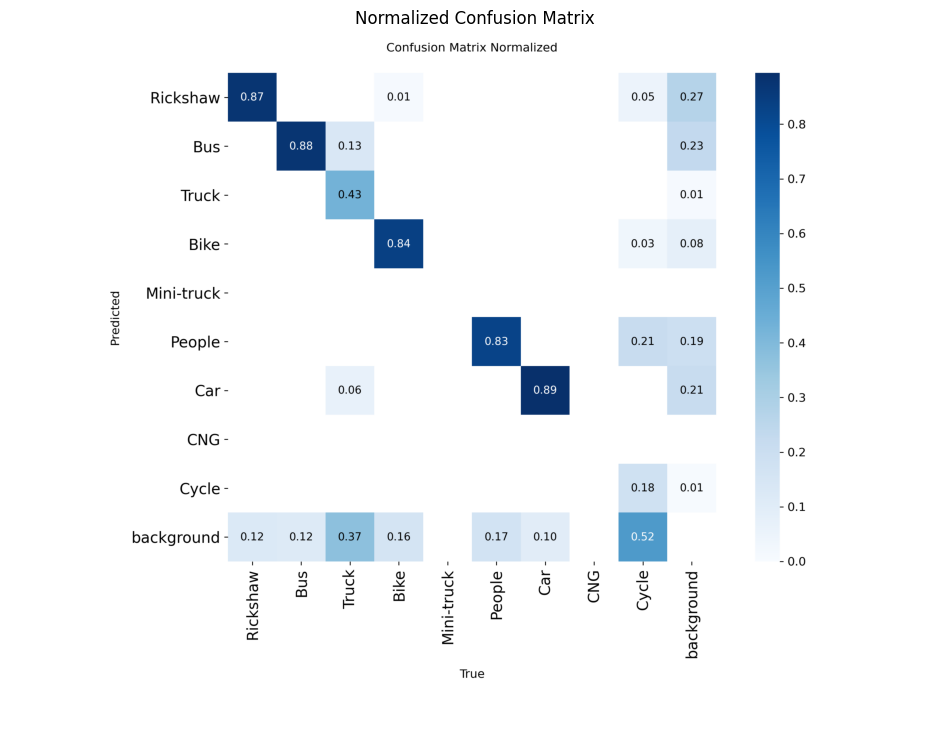

In [8]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ============================================================
# 1. Setup & Validation
# ============================================================
# Load your best model (check the path)
best_model_path = "/kaggle/working/traffic_simclr_project/outputs/yolo12_simclr_finetuned/weights/best.pt"
data_yaml_path = "/kaggle/working/traffic_simclr_project/data.yaml"

model = YOLO(best_model_path)

print("➤ Generating Confusion Matrix on Test Set...")

# Run Validation (Setting plots=True will save the Confusion Matrix)
metrics = model.val(
    data=data_yaml_path,
    split="test",        # I want a matrix on the test data.
    imgsz=640,
    batch=16,
    plots=True,          # This is very important, this is what saves the image
    device=0             # 1 GPU is enough for validation
)

# ============================================================
# 2. Display Confusion Matrix
# ============================================================
# Extract the folder where Ultralytics saved the results
save_dir = Path(metrics.save_dir)
confusion_matrix_path = save_dir / "confusion_matrix.png"
norm_confusion_matrix_path = save_dir / "confusion_matrix_normalized.png"

# Showing the general Confusion Matrix
if confusion_matrix_path.exists():
    img = mpimg.imread(confusion_matrix_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("⚠ Confusion Matrix image not found!")

# Showing the normalized confusion matrix (better to understand as percentages)
if norm_confusion_matrix_path.exists():
    img_norm = mpimg.imread(norm_confusion_matrix_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img_norm)
    plt.axis('off')
    plt.title("Normalized Confusion Matrix")
    plt.show()

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


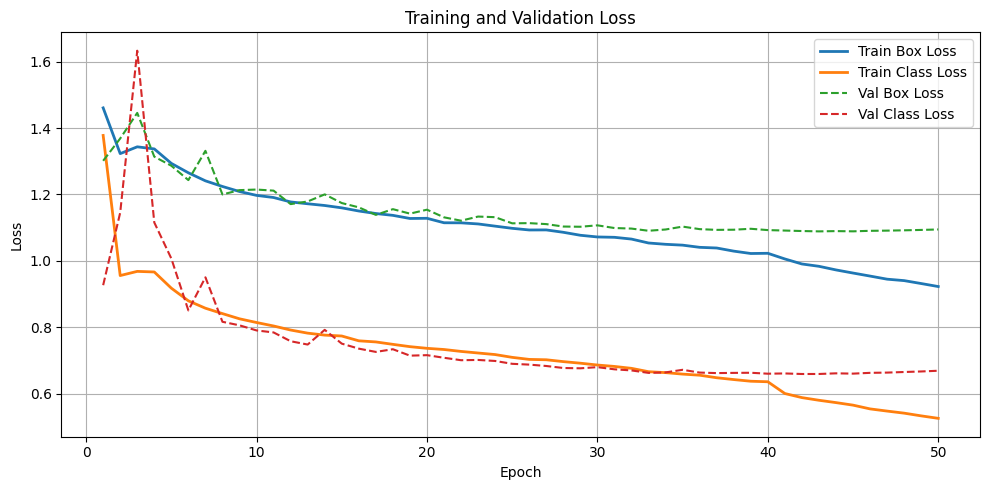

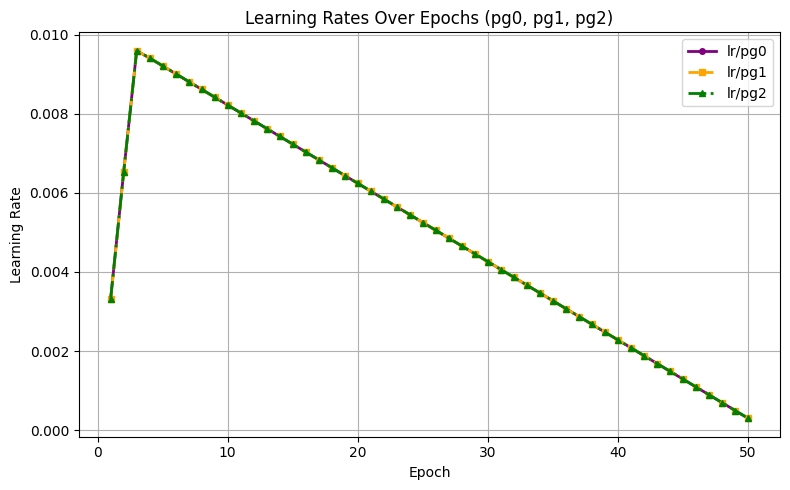

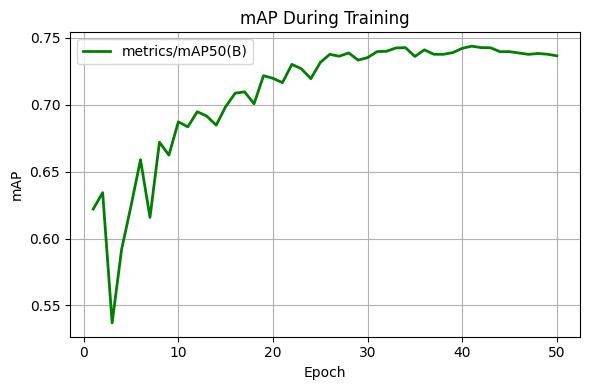

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

WORK2 = Path("/kaggle/working/traffic_simclr_project/outputs/yolo12_simclr_finetuned") 

# Path to results.csv
results_path = "/kaggle/working/traffic_simclr_project/outputs/yolo12_simclr_finetuned/results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")

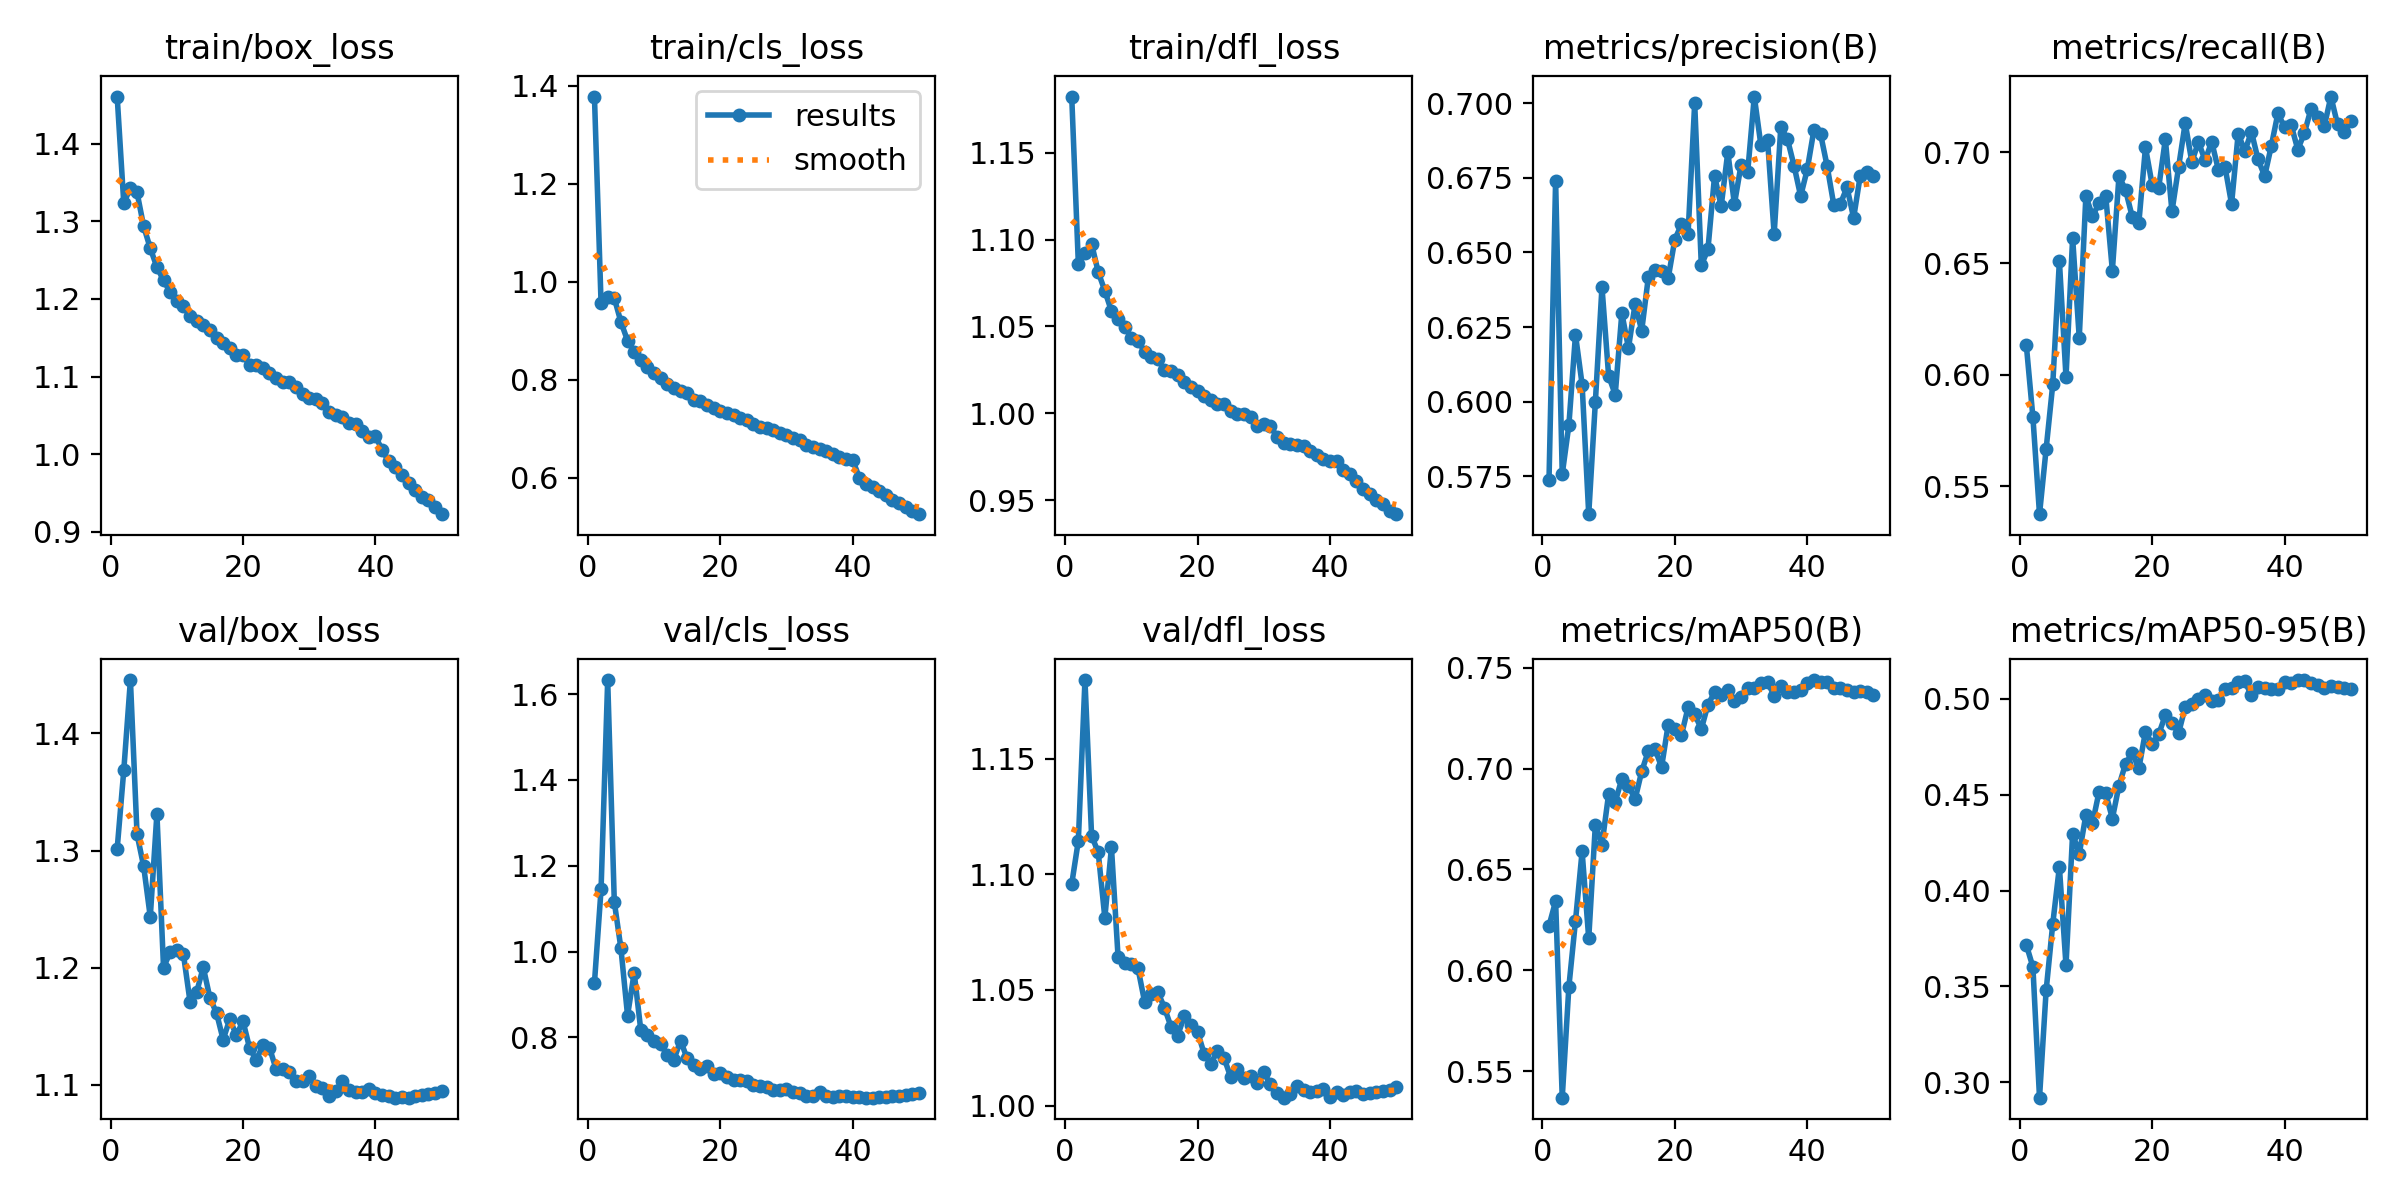

In [10]:
from PIL import Image
from IPython.display import display

results_img = "/kaggle/working/traffic_simclr_project/outputs/yolo12_simclr_finetuned/results.png"
img = Image.open(results_img)
display(img)

➤ Loading model from: /kaggle/working/traffic_simclr_project/outputs/yolo12_simclr_finetuned/weights/best.pt

➤ Running Validation on Test Set...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1955.1±527.3 MB/s, size: 82.2 KB)
val: Scanning /kaggle/working/traffic_simclr_project/dataset_split/test/labels.cache... 2368 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2368/2368 3.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 148/148 4.4it/s 33.7s
                   all       2368      23574      0.703      0.662       0.72      0.491
              Rickshaw       1969       6246      0.819      0.827      0.904      0.629
                   Bus       1950       52

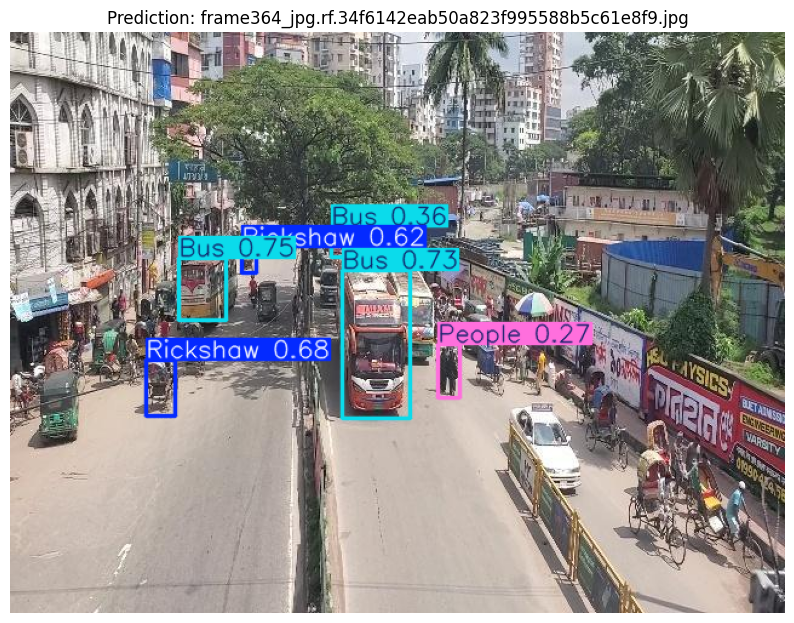

In [11]:
from ultralytics import YOLO
from pathlib import Path
import random
import matplotlib.pyplot as plt
import torch

# ============================================================
# 1. Path Setup (Automatic Detection)
# ============================================================
WORK_DIR = Path("/kaggle/working/traffic_simclr_project")
OUTPUT_DIR = WORK_DIR / "outputs"

# Checking which folder contains the wait file (Multi-GPU or Single-GPU)
if (OUTPUT_DIR / "yolo12_simclr_ddp").exists():
    project_name = "yolo12_simclr_ddp"  # If the last run was on Multi-GPU
else:
    project_name = "yolo12_simclr_finetuned" # If on Single-GPU

best_pt = OUTPUT_DIR / project_name / "weights/best.pt"
DATA_YAML = WORK_DIR / "data.yaml"
TEST_IMAGES_DIR = WORK_DIR / "dataset_split/test/images"

print(f"➤ Loading model from: {best_pt}")

# ============================================================
# 2. Validation Loop
# ============================================================
# Loading the model
model_det = YOLO(str(best_pt))

# Device Detection
device_config = [0, 1] if torch.cuda.device_count() > 1 else 0

print("\n➤ Running Validation on Test Set...")
results = model_det.val(
    data=str(DATA_YAML),
    split="test",
    imgsz=640,
    batch=16,
    device=device_config
)

# ============================================================
# 3. Print Metrics
# ============================================================
try:
    # Direct access to new versions
    mp, mr, map50, map5095 = results.mean_results()
except:
   # If the version is different, extract it manually
    mp = results.box.mp
    mr = results.box.mr
    map50 = results.box.map50
    map5095 = results.box.map

print("\n" + "="*30)
print("🏆 VALIDATION METRICS")
print("="*30)
print(f" Precision (mP)    : {mp:.4f}")
print(f" Recall    (mR)    : {mr:.4f}")
print(f" mAP@0.50          : {map50:.4f}")
print(f" mAP@0.50-0.95     : {map5095:.4f}")
print("="*30 + "\n")

# ============================================================
# 4. Visualize Random Prediction
# ============================================================
test_imgs = list(TEST_IMAGES_DIR.glob("*.jpg")) + list(TEST_IMAGES_DIR.glob("*.png"))

if test_imgs:
    img_path = random.choice(test_imgs)
    print(f"➤ Visualizing prediction for: {img_path.name}")
    
   # Run predictions (1 GPU is enough for visualization)
    pred = model_det.predict(
        source=str(img_path),
        imgsz=640,
        conf=0.25,
        device=0, 
        verbose=False
    )[0]
    
  # Plotting
    plt.figure(figsize=(10, 10))
    plt.imshow(pred.plot()[:, :, ::-1])  # Convert BGR -> RGB
    plt.axis("off")
    plt.title(f"Prediction: {img_path.name}")
    plt.show()
else:
    print("⚠ No test images found for visualization.")